# Segmentering vha. RFM

Segmentering kan give os en bedre forståelse af behov hos kunderne:

- Muligheder for vækstpotentiale blandt eksisterende kunder bl.a. ved at vide hvad de har behov for før de bestiller
- Proaktiv og data-drevet markedsføring for at tiltrække flere kunder.

Hvis man ikke har demokrafiske data, kan man forsøge sig med at segmentere udfra købsadfærd. 

I den her notesbog prøver jeg RFM-metoden. Det er en simpel som går ud på at kategorisere kunder baseret på tre parametre ([kilde](https://www.putler.com/rfm-analysis/)):
- **R**ecency: hvornår en kunde sidst har købt noget (antal dage siden sidste købsdato)
- **F**requency: antallet af ordrer
- **M**onetary: total omsætning

## Kode

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
from IPython.display import display

sns.set()
sns.set_context('talk', font_scale=1)

In [2]:
def draw_box_and_dist_plots(x: pd.Series, bins=50):
    fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True, gridspec_kw= {"height_ratios": (0.15, 1)})
    sns.boxplot(x, ax=axes[0])
    sns.distplot(x, kde=False, bins=bins, ax=axes[1])

    mode, mean, median = x.mode()[0], x.mean(),  x.median()
    for ax in axes:
        ax.axvline(mode, color='green', linestyle='-')
        ax.axvline(mean, color='red', linestyle='--')
        ax.axvline(median, color='orange', linestyle='-')
    axes[1].legend({
        f'Typeværdi: {mode:.0f}': mode,
        f'Gennemsnit: {mean:.0f}': mean,
        f'Median: {median:.0f}': median 
    })
    return axes

## Data præprocessering

In [3]:
df_data = pd.read_csv('data/ecommerce-data.zip', encoding='ISO-8859-1')

In [4]:
df_data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Data består af fakturalinjer. RFM-metoden er afhængig at der er kunde-information. Derfor vil jeg fjerne de rækker som ikke har kunde-ID.

In [5]:
df_data = df_data[~df_data.CustomerID.isna()]

Jeg undersøger om der er manglende værdier:

In [6]:
pd.DataFrame(df_data.isna().sum(), columns=['Antal']).T

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Antal,0,0,0,0,0,0,0,0


For at gøre det nemmere for mig selv vil jeg trække faktura-informationer over i en separat DataFrame.

In [7]:
df_data['Amount'] = df_data['Quantity'] * df_data['UnitPrice']

df_invoices = df_data.groupby('InvoiceNo').agg(**{
    'CustomerID': ('CustomerID', 'first'),
    'NumberOfLines': ('InvoiceNo', 'count'),
    'TotalAmount': ('Amount', 'sum'),
    'TotalQuantity': ('Quantity', 'sum'),
    'Country': ('Country', 'first'),
    'Date': ('InvoiceDate', 'first')
}).reset_index()

df_invoices['CustomerID'] = df_invoices.CustomerID.astype('int32')
df_invoices['Date'] = df_invoices['Date'].astype('datetime64[ns]')

In [8]:
df_invoices.sample(5)

,InvoiceNo,CustomerID,NumberOfLines,TotalAmount,TotalQuantity,Country,Date
18996,C541826,18260,3,-18.25,-6,United Kingdom,2011-01-21 17:04:00
4453,547850,14472,62,311.57,216,United Kingdom,2011-03-27 12:06:00
14286,571744,14434,2,169.20,72,United Kingdom,2011-10-19 10:43:00
8155,557018,14285,1,5.90,2,United Kingdom,2011-06-16 12:36:00
14633,572661,17193,13,760.74,946,United Kingdom,2011-10-25 12:38:00


Jeg har også brug for at aggregere informationer om hver kunde så jeg har opretter en DataFrame til det:

In [9]:
df_customers = df_invoices.groupby('CustomerID').agg(**{
    'FirstInvoiceDate': ('Date', 'min'),
    'LastInvoiceDate': ('Date', 'max'),
    'InvoiceCount': ('InvoiceNo', 'count'),
    'Revenue': ('TotalAmount', 'sum'),
    'Country': ('Country', 'first'),
})

In [10]:
df_customers.head(5)

,FirstInvoiceDate,LastInvoiceDate,InvoiceCount,Revenue,Country
CustomerID,,,,,
12346,2011-01-18 10:01:00,2011-01-18 10:17:00,2,0.00,United Kingdom
12347,2010-12-07 14:57:00,2011-12-07 15:52:00,7,4310.00,Iceland
12348,2010-12-16 19:09:00,2011-09-25 13:13:00,4,1797.24,Finland
12349,2011-11-21 09:51:00,2011-11-21 09:51:00,1,1757.55,Italy
12350,2011-02-02 16:01:00,2011-02-02 16:01:00,1,334.40,Norway


Jeg vil også fokusere på kunder som butikken tjener penge på:

In [11]:
df_customers = df_customers[df_customers.Revenue > 1]

## Recency

Recency et udtryk for hvor "frisk" kunde-kontakten er. Man kan kvanticere det på er at udregne antal måneder eller dage en kunde sidst har handlet i butikken given en reference dage f.eks. dags dato.

In [12]:
ref_date = df_invoices.Date.max() + pd.DateOffset(days=1)
ref_date

Timestamp('2011-12-10 12:50:00')

Jeg vælger at udregne antal dage fordi det giver mig en højere "opløsning". Derfra kan jeg altid vælge at udregne måneder eller uger.

In [13]:
df_customers['DaysSinceLastInvoice'] = df_customers.LastInvoiceDate.map(lambda date: (ref_date - date).days)

In [14]:
df_customers[['DaysSinceLastInvoice']].describe().T

,count,mean,std,min,25%,50%,75%,max
DaysSinceLastInvoice,4317.0,90.370628,99.157796,1.0,17.0,49.0,138.0,374.0


- Værdierne spænder fra en dag (frisk) til over et år (gammel). 
- Halvdelen af de observerede kunder er blevet faktureret indenfor 50 dage siden referencedatoen (10. dec 2011).
- 75% er faktureret indenfor 138 dage -- ca. 4-5 måneder.
- Størstedelen af kunderne er rimelig "friske" dvs. de ligger koncentreret i den ene ende af friskheds-skalaen.

Hvordan ser fordelingen ud?

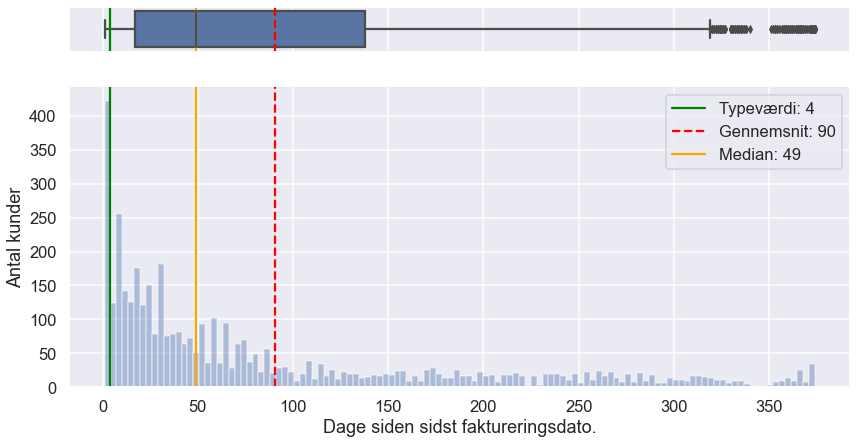

In [15]:
axes = draw_box_and_dist_plots(df_customers.DaysSinceLastInvoice, bins=120);
axes[0].set_xlabel('')
axes[1].set_xlabel('Dage siden sidst faktureringsdato.')
axes[1].set_ylabel('Antal kunder');

Der er tale om en long-tail fordeling hvor rigtig mange kunder er friske.
En mulig forklaring kunne være at Black Friday ligger i november hvor butikker generelt ser en større salgsvolumen. Da nogle af kunderne er grosister kan det tænkes at de handler nogle få måneder op til (og efter) for at fylde deres lagre op.

Det næste man skal tage stilling til er hvordan man genererer en Recency-score på baggrund af dataene. Man kan udregne en score baseret på intervaller eller fraktiler.

Udregningsmetoden er i sidste ende afhængig af forretning. Her vælger jeg at udregne en score fra 1 (dårligst) til 5 (bedst) ved at inddele observationerne i 5 fraktiler.

In [16]:
df_customers['RecencyValue'] = df_customers.DaysSinceLastInvoice

In [17]:
df_customers['RecencyScore'] = pd.qcut(df_customers.RecencyValue, q=5, labels=[5, 4, 3, 2, 1]).astype('int32')

In [18]:
df_customers.groupby('RecencyScore')[['RecencyValue']].describe()

RecencyValue                                                     \
                    count        mean        std    min    25%    50%    75%   
RecencyScore                                                                   
1                   863.0  264.878331  57.831063  175.0  215.0  261.0  310.5   
2                   857.0  111.942824  32.147081   71.0   82.0  107.0  138.0   
3                   860.0   49.088372  11.063647   32.0   39.0   50.0   59.0   
4                   863.0   21.414832   5.554987   12.0   17.0   22.0   26.0   
5                   874.0    5.615561   3.330382    1.0    3.0    5.0    9.0   

                     
                max  
RecencyScore         
1             374.0  
2             174.0  
3              70.0  
4              31.0  
5              11.0

- Den bedste score på 5 bliver tildelt kunder som har handlet indenfor 11 dage før den 10. december 2011. 
- Kunder som har købt varer mellem ca. 5-6 måneder til over et år siden får den dårligste Recency-score på 1. 

## Frequency

Det næste er Freqency som betegner hyppigheden af ordrer/handler som forretningen modtager fra en kunde.

In [19]:
df_customers[['InvoiceCount']].describe().T

,count,mean,std,min,25%,50%,75%,max
InvoiceCount,4317.0,5.119296,9.389294,1.0,1.0,3.0,6.0,248.0


Medianen er 3 fakturaer og 75% af kunderne har foretaget under 6 bestillinger. Det er tydeligt at fordelingen er ret skæv.

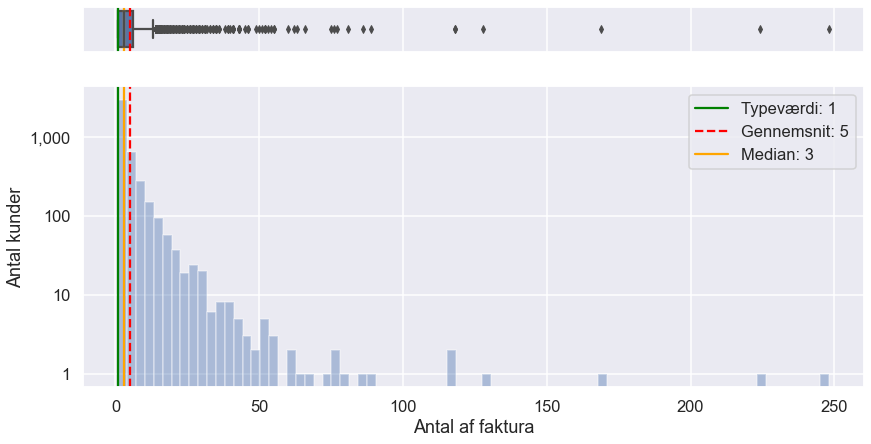

In [20]:
axes = draw_box_and_dist_plots(df_customers.InvoiceCount, bins=80);
axes[0].set_xlabel('')
axes[1].set_yscale('log')
axes[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axes[1].set_xlabel('Antal af faktura')
axes[1].set_ylabel('Antal kunder');

In [21]:
count_threshold = 50
print('{} ud af {} kunder blev faktureret mere end {} gange.'.format((df_customers.InvoiceCount > count_threshold).sum(), len(df_customers), count_threshold))

24 ud af 4317 kunder blev faktureret mere end 50 gange.


En lille andel af kunderne har stået et stort antal faktureringer. De afviger meget fra størstedelen af kunderne. Man kan vælge at betragte dem som outliers og fjerne dem. Man kan 

Step 1: udregn hvor sjælden hver enkel værdi (InvoiceCount) er i forhold resten

In [22]:
df_invoice_count_rarity_pct = df_customers.InvoiceCount.value_counts() / len(df_customers) * 100

Step 2: find de InvoiceCount-værdier som er større end 0.5% af alle kunder.

In [23]:
pct_threshold = 0.5
above_threshold_counts = list(df_invoice_count_rarity_pct[df_invoice_count_rarity_pct >= pct_threshold].index)

Step 3: fjern disse kunder fra kunde-tabellen

In [24]:
n_before = len(df_customers)
df_customers = df_customers[df_customers.InvoiceCount.isin(above_threshold_counts)]
n_after = len(df_customers)
print(f'Slettet {n_before - n_after} kunder.')

Slettet 191 kunder.


Hvordan ser fordelingen ud nu?

In [25]:
df_customers[['InvoiceCount']].describe().T

,count,mean,std,min,25%,50%,75%,max
InvoiceCount,4126.0,3.776054,3.449974,1.0,1.0,2.0,5.0,18.0


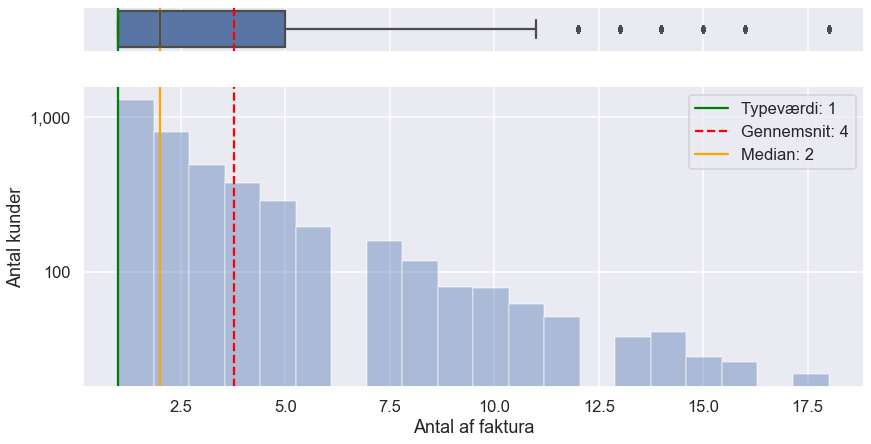

In [26]:
axes = draw_box_and_dist_plots(df_customers.InvoiceCount, bins=20);
axes[0].set_xlabel('')
axes[1].set_yscale('log')
axes[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axes[1].set_xlabel('Antal af faktura')
axes[1].set_ylabel('Antal kunder');

Intervallet er reduceret. Der er stadigvæk rigtig mange kunder som har kun har handlet en eller to gange i løbet af året. En fraktil-baseret score giver ikke så meget mening. I stedet vil jeg definere inddele InvoiceCount-værdier i fem 5 intervaller:

In [27]:
df_customers['FrequencyValue'] = df_customers['InvoiceCount']

In [28]:
df_customers['FrequencyScore'] = pd.cut(
    df_customers.groupby('FrequencyValue').ngroup(), 
    bins=5, labels=[1, 2, 3, 4, 5]
).astype('int32')

In [29]:
df_customers.groupby('FrequencyScore')[['FrequencyValue']].describe()

FrequencyValue                                               \
                        count       mean       std   min   25%   50%   75%   
FrequencyScore                                                               
1                      2944.0   1.985734  1.054963   1.0   1.0   2.0   3.0   
2                       639.0   5.796557  0.808994   5.0   5.0   6.0   6.0   
3                       275.0   8.858182  0.831561   8.0   8.0   9.0  10.0   
4                       151.0  11.841060  0.800772  11.0  11.0  12.0  12.5   
5                       117.0  15.435897  1.446665  14.0  14.0  15.0  16.0   

                      
                 max  
FrequencyScore        
1                4.0  
2                7.0  
3               10.0  
4               13.0  
5               18.0

- Bedste score på 5: kunder som har handlet 14-18 gange i løbet af hele perioden.
- Dårligst score på 1: kunder med ordrer mellem 1 og 4 i løbet af hele perioden.

## Monetary

Det sidste parameter Monetary beskriver hvor stor er den samlede omsætning per kunde.

In [30]:
df_customers[['Revenue']].describe().T

,count,mean,std,min,25%,50%,75%,max
Revenue,4126.0,1174.886525,1812.798611,2.9,291.91,621.445,1419.22,50415.49


Beløb varierer fra £2,9 til £50.415. Hvordan ser fordelingen ud?

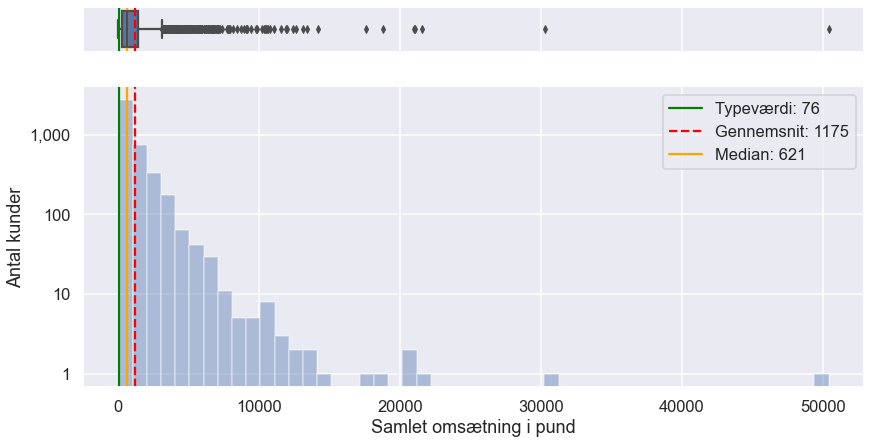

In [31]:
axes = draw_box_and_dist_plots(df_customers.Revenue, bins=50);
axes[0].set_xlabel('')
axes[1].set_yscale('log')
axes[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axes[1].set_xlabel('Samlet omsætning i pund')
axes[1].set_ylabel('Antal kunder');

Igen ser vi outliers som man kan vælge at fjerne. I det her tilfælde vil jeg beholde dem og udregne en score vha. fraktiler:

In [32]:
df_customers['MonetaryValue'] = df_customers['Revenue']

In [33]:
df_customers['MonetaryScore'] = pd.qcut(df_customers.MonetaryValue, q=5, labels=[1, 2, 3, 4, 5]).astype(int)

In [34]:
df_customers.groupby('MonetaryScore')[['MonetaryValue']].describe()

MonetaryValue                                              \
                      count         mean          std      min      25%   
MonetaryScore                                                             
1                     826.0   147.855642    53.411922     2.90   110.60   
2                     825.0   337.609759    58.453673   237.07   292.00   
3                     825.0   627.146148   106.500526   452.89   537.83   
4                     825.0  1217.546339   254.413634   841.64   999.70   
5                     825.0  3545.519625  2946.290886  1740.60  2140.22   

                                             
                    50%       75%       max  
MonetaryScore                                
1               152.475   192.435    236.78  
2               333.560   383.700    452.85  
3               621.660   709.710    841.52  
4              1174.580  1419.540   1740.48  
5              2757.070  3844.220  50415.49

- De bedste kunder er dem som butikken har faktureret mellem 1.740 til 50.415 pund.
- Bundkarakter på kunder som sammenlagt har købt mellem  2 og 236 pund.

## RFM samlet score

Den samlede RFM-score kan "beregnes" ved at sammenkæde de enkelte R, F og M scores i én:

In [35]:
df_customers['RFMScore'] = (
      df_customers.RecencyScore.astype('str')
    + df_customers.FrequencyScore.astype('str')
    + df_customers.MonetaryScore.astype('str')
)

In [36]:
(df_customers['RFMScore']
   .value_counts()
   .reset_index()
   .rename(columns={'index': 'RFMScore', 'RFMScore': 'CustomerCount'})
   .sort_values('RFMScore', ascending=False)
)

,RFMScore,CustomerCount
25,555,61
69,554,2
23,545,62
51,544,9
17,535,79
...,...,...
49,115,15
26,114,59
9,113,134
1,112,263


Ved at konkatenere de enkelte scores får vi 82 forskellige værdier. Der er 61 kunder som har fået top-score på 555 og den dårligste score er givet til 352 kunder. 

En måde at segmentere kunderne på er at inddele dem i prædefinerede navngivne grupper udfra de enkelte score. Her er et eksempel på en inddeling (tabel lånt af [R-Bloggers](https://www.r-bloggers.com/customer-segmentation-using-rfm-analysis/)).


<img src="figures/rfm-segments-table.png" width="700" title="RFM segment tabel fra R Bloggers" />




Definer tabellen:

In [37]:
segment_table = {
  'Champions': [(4, 5), (4, 5), (4, 5)],
  'Loyal Customers': [(2, 4), (3, 4), (4, 5)],
  'Potential Loyalist': [(3, 5), (1, 3), (1, 3)],
  'New Customers': [(4, 5), (1, 2), (1, 2)],
  'Promising': [(3, 4), (1, 2), (1, 2)],   
  'Need Attention': [(3, 4), (3, 4), (3, 4)],
  'About To Sleep': [(2, 3), (1, 3), (1, 3)],
  'At Risk': [(1, 3), (2, 5), (2, 5)],
  "Can't Lose Them": [(1, 2), (4, 5), (4, 5)],
  'Hibernating': [(2, 3), (2, 3), (2, 3)],
  'Lost': [(1, 2), (1, 2), (1, 2)]
}

Genererer kombinationerne:

In [38]:
score_segment_map = dict()
for segment_name, ranges in segment_table.items():
    r_range, f_range, m_range = [(r[0], r[1]+1) for r in ranges]
    for i in range(*r_range):
        for j in range(*f_range):
            for k in range(*m_range):
                score_segment_map[f'{i}{j}{k}'] = segment_name

Tildel segmentet til hver kunde:

In [39]:
df_customers['RFMSegment'] = df_customers.RFMScore.map(lambda v: score_segment_map[v] if v in score_segment_map else 'None')

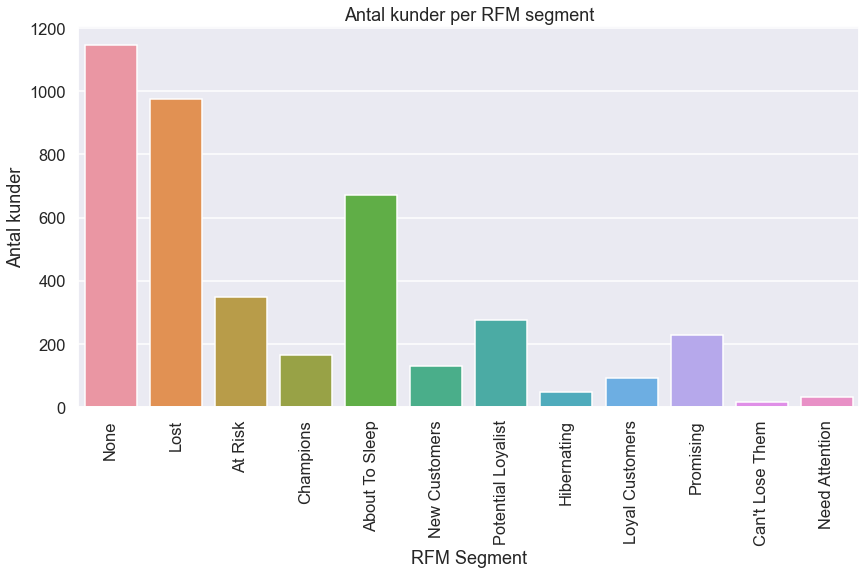

In [40]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.countplot(df_customers.RFMSegment, ax=ax)
ax.set_ylabel('Antal kunder')
ax.set_xlabel('RFM Segment')
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('Antal kunder per RFM segment');

Det ser lovende ud men der er en del kunder under None-segmentet. Sandsynligvis skyldes det at bestemte kombinationer som er i observationerne mangler i RFM-tabellen.

En alternative metode er at kombinere Frequency og Monetary fordi de samlet set udtrykker hvor meget en kunde køber (se evt. [Putler](https://www.putler.com/rfm-analysis/)).
Jeg bruger gennemsnittet af de to scores.

In [41]:
df_customers['FMScore'] = np.round((df_customers.FrequencyScore + df_customers.MonetaryScore) / 2)
df_customers['FMScore'] = df_customers.FMScore.astype('int32')

In [42]:
df_customers['RFMScoreV2'] = (
      df_customers.RecencyScore.astype('str')
    + df_customers.FMScore.astype('str')
)

In [43]:
rfm_segment_table_v2 = {
  'Champions': [(4, 5), (4, 5)],
  'Loyal Customers': [(2, 5), (3, 5)],
  'Potential Loyalist': [(3, 5), (1, 3)],
  'New Customers': [(4, 5), (1, 2)],
  'Promising': [(3, 4), (1, 2)],   
  'Need Attention': [(2, 3), (2, 3)],
  'About To Sleep': [(2, 3), (1, 3)],
  'At Risk': [(1, 3), (2, 5)],
  "Can't Lose Them": [(1, 2), (4, 5)],
  'Hibernating': [(1, 2), (1, 2)],
  'Lost': [(1, 3), (1, 3)]
}

score_segment_v2_map = dict()
for segment_name, ranges in rfm_segment_table_v2.items():
    r_range, fm_range = [(r[0], r[1]+1) for r in ranges]
    for i in range(*r_range):
        for j in range(*fm_range):
            score_segment_v2_map[f'{i}{j}'] = segment_name

df_customers['RFMSegmentV2'] = df_customers.RFMScoreV2.map(lambda v: score_segment_v2_map[v])

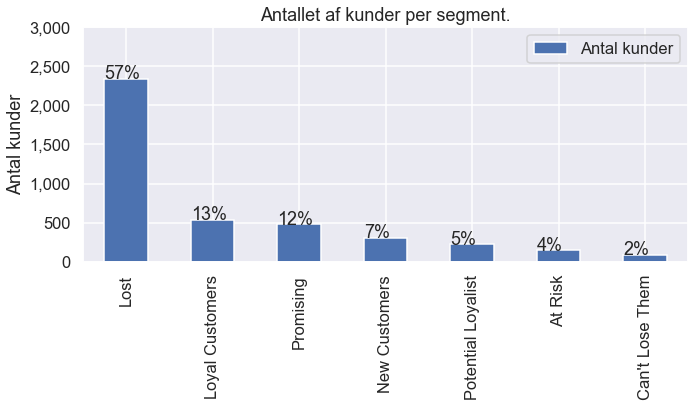

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))

df_plot_data = (
    df_customers[['LastInvoiceDate', 'RFMSegmentV2']]
        .groupby('RFMSegmentV2')
        .count()
        .rename(columns={'LastInvoiceDate':'CustomerCount'})
        .sort_values('CustomerCount', ascending=False)
)
df_plot_data.plot(kind='bar', ax=ax)

total_count = df_plot_data['CustomerCount'].sum()
pct_vals = list(df_plot_data['CustomerCount'] / total_count)
for i, p in enumerate(ax.patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{pct_vals[i]:.0%}', (x, y + height + 0.01))

ax.set_xlabel('')
ax.set_ylabel('Antal kunder')
ax.set_ylim([0, 3000])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.legend(['Antal kunder'])

ax.set_title('Antallet af kunder per segment.')
fig.tight_layout();

**Lost** er den kundegruppe med de lavest scores. 
- Da de udgør over halvdelen af hele kunde-portfolio, kan det muligvis betale sig at forstå dem bedre.
- Måske er de engangskunder som handler rundt i forskellige webshops fordi de er pris-sensitive.
- Hvis dette segment ikke var så stor, kunne man overveje om det kan svare sig at bruge mere tid på dem. 


**Loyal Customers** og **Potential Loyalist** kundesegmentet har RFM-score i den mellem-høje ende.
 - Potential Loyalist: har handlet i nyere tid end den loyale kundegruppe men bruger ikke så mange penge.
 - De handler ofte og bruger relativ mange penge på forretningen.
 - Værd at kigge på hvilke produkter de køber for at blive klog på deres behov.
 - Nogle af disse kunder kan måske lokkes til at lave produkt-reviews. 
 - Kan muligvis være interesseret i at købe dyrere varer.
 

**Promising** og **New Customers** har mellem til høj Recency-score men lav FM-score
 - De har handlet for kort tid siden, men har ikke handlet så ofte og/eller har ikke brugt store summer.
 - Man kan prøve at påvirke dem så de får et godt indtryk af webshoppen. Man kan sende velkomst-tilbud, gratis vareprøver mm.


**Can't Lose Them** og **At Risk** har lav-mellem R-score men høj FM-score
 - Det er noget tid siden kunderne i denne gruppe har købt noget i forhold til de andre kunder, men har tidligere handlet flere gange og brugt mange penge.
 - Undersøg hvad man kan gøre for at få dem til at handle noget oftere. Spørg om deres behov via et spørgeskemaundersøgelse.

  
